# TODO
Models to add: fasttext, MLP

metrics: latency, accuracy, precision, recall, F1  
<hr>
pridat embedd model (fastembed)

embedding models: BAAI/bge-small-en-v1.5, jinaai/jina-embeddings-v2-small-en, sentence-transformers/all-MiniLM-L6-v2
<hr>
otestovat potom na llame
<hr>
vygenerovat 100 edge case dat
"What are the laws for ..bullshit..", through validation

In [1]:
from llm_classifier import LMTrainer, LMClassifier
from svm_tfidf import SVMClassifier
from fasttext_model import *
from sklearn.feature_extraction.text import TfidfVectorizer
from utilities import *
import os
import dotenv
import requests
import fasttext
from fastembed import TextEmbedding

dotenv.load_dotenv()

c:\Users\riso\Desktop\Prompt-Classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Models

In [2]:
def get_models() -> list:
    url = f"{os.getenv("PROXY_URL")}/models"
    headers = {"Content-Type": "application/json", "Authorization": f"Bearer {os.getenv("OPENAI_API_KEY")}"}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        models = response.json()
        models = [model["id"] for model in models["data"]]
        return models
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
available_models = get_models()
if available_models:
    print("Available models:", available_models)
else:
    print("Failed to retrieve models")

Available models: ['gpt-4o', 'llama3.1:70b', 'llama3.1:8b', 'o1-mini', 'o1-preview', 'gpt-4', 'gpt-4o-mini', 'gpt-4-turbo']


# Embedding Models

In [3]:
baai_embedding = TextEmbedding(model_name="BAAI/bge-small-en-v1.5")
jina_embedding = TextEmbedding(model_name="jinaai/jina-embeddings-v2-small-en")
miniLM_embedding = TextEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


# GPT-4o-mini

In [4]:
api_key = os.getenv("OPENAI_API_KEY")
proxy_url = os.getenv("PROXY_URL")

gpt_model = LMClassifier(api_key=api_key, proxy_url=proxy_url, domain='law', model_name='gpt-4o-mini', train_size=100, test_size=300)
gpt_model.load_data(open_path="../data/open_domain_data.csv", specific_path="../data/specific_domain_data.csv")

trainer = LMTrainer(gpt_model.train_data)

Train data: 100
Test data: 300


Going to sample between 1 and 4 traces per predictor.
Will attempt to bootstrap 5 candidate sets.


Average Metric: 97 / 100  (97.0): 100%|██████████| 100/100 [00:00<00:00, 259.13it/s]


New best score: 97.0 for seed -3
Scores so far: [97.0]
Best score so far: 97.0


Average Metric: 98 / 100  (98.0): 100%|██████████| 100/100 [00:00<00:00, 329.50it/s]


New best score: 98.0 for seed -2
Scores so far: [97.0, 98.0]
Best score so far: 98.0


  4%|▍         | 4/100 [00:00<?, ?it/s]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 99 / 100  (99.0): 100%|██████████| 100/100 [00:00<00:00, 292.61it/s]


New best score: 99.0 for seed -1
Scores so far: [97.0, 98.0, 99.0]
Best score so far: 99.0


  4%|▍         | 4/100 [00:00<00:00, 289.69it/s]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 98 / 100  (98.0): 100%|██████████| 100/100 [00:00<00:00, 258.66it/s]


Scores so far: [97.0, 98.0, 99.0, 98.0]
Best score so far: 99.0


  2%|▏         | 2/100 [00:00<?, ?it/s]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 98 / 100  (98.0): 100%|██████████| 100/100 [00:00<00:00, 219.63it/s]


Scores so far: [97.0, 98.0, 99.0, 98.0, 98.0]
Best score so far: 99.0


  1%|          | 1/100 [00:00<00:00, 102.05it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 98 / 100  (98.0): 100%|██████████| 100/100 [00:00<00:00, 292.69it/s]


Scores so far: [97.0, 98.0, 99.0, 98.0, 98.0, 98.0]
Best score so far: 99.0


  2%|▏         | 2/100 [00:00<?, ?it/s]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 99 / 100  (99.0): 100%|██████████| 100/100 [00:00<00:00, 296.15it/s]


Scores so far: [97.0, 98.0, 99.0, 98.0, 98.0, 98.0, 99.0]
Best score so far: 99.0


  2%|▏         | 2/100 [00:00<?, ?it/s]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 99 / 100  (99.0): 100%|██████████| 100/100 [00:00<00:00, 177.60it/s]


Scores so far: [97.0, 98.0, 99.0, 98.0, 98.0, 98.0, 99.0, 99.0]
Best score so far: 99.0
8 candidate programs found.


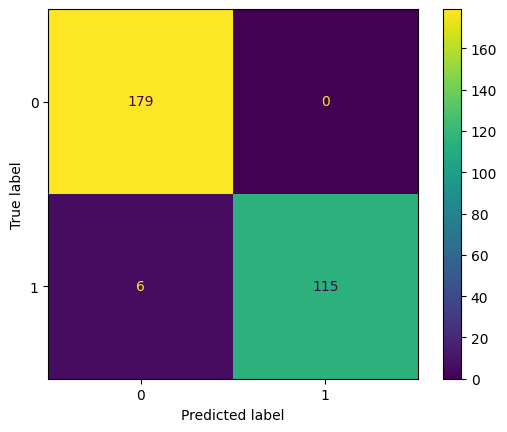

Total cost is: 0.00078375$
F1 score: 0.97
Accuracy: 0.98
Recall: 0.95
Precision: 1.00


In [5]:
predictions = []
true_labels = []
total_cost = 0

compiled_model = trainer.optimize_model()

for example in gpt_model.test_data:
    prediction = trainer.optimized_model(prompt=example.prompt, domain=example.domain).label
    predictions.append(prediction)
    true_labels.append(example.label)
    total_cost += calculate_prompt_cost(example.prompt+example.domain, completion=prediction, model_name=gpt_model.model_name)

f1, accuracy, recall, precision = trainer.evaluate(predictions, true_labels)

print(f"Total cost is: {total_cost:.8f}$")
print(f"F1 score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

#trainer.save_model(f"../models/{gpt_model.model_name}.json")

In [6]:
trainer.load_model(f"../models/{gpt_model.model_name}.json")

results = trainer.predict(prompt="What are the laws for eating in car?", domain="law")

print(f"Prediction results: {results}")

Model loaded from ../models/gpt-4o-mini.json
Prediction results: 1


# SVM-TFIDF

In [ ]:
config = {
    'C': 0.5,
    'train_size': 5_000,
    'test_size': 10_000,
    'seed': 22,
    'embedding': baai_embedding,
}

svm_classifier = SVMClassifier(config=config)

X_train, X_test, y_train, y_test = svm_classifier.prepare_data(open_path="../data/open_domain_data.csv", 
                                                                specific_path="../data/specific_domain_data.csv")

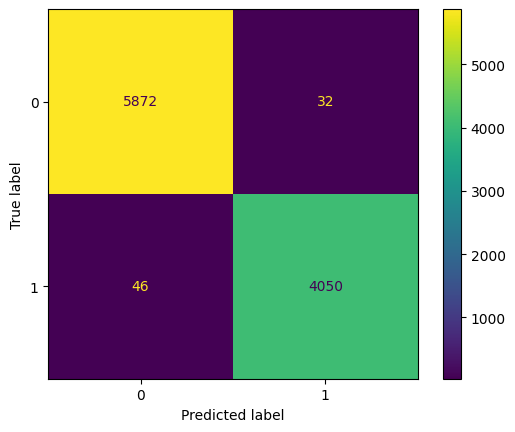

F1 score: 0.99
Accuracy: 0.99
Recall: 0.99
Precision: 0.99


In [8]:
svm_classifier.train(X_train, y_train)
f1, accuracy, recall, precision = svm_classifier.evaluate(X_test, y_test)

print(f"F1 score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

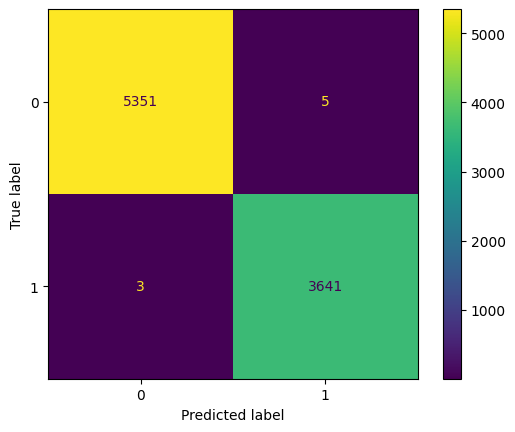

F1 score: 1.00
Accuracy: 1.00
Recall: 1.00
Precision: 1.00


In [9]:
f1, accuracy, recall, precision = svm_classifier.evaluate(X_train, y_train)

print(f"F1 score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

In [10]:
# Save the model
svm_classifier.save_model(model_path=f'../models/{svm_classifier.model_name}.joblib')

Model saved to ../models/SVM_TFIDF.joblib


In [11]:
result = svm_classifier.predict("What are the laws for eating in car?")

print(result)

[1]


# FastText

In [12]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [13]:
fasttext_model = FastText(train_size=20_000, test_size=5000)

train_file = "../data/fasttext_train.txt"
test_file = "../data/fasttext_test.txt"

fasttext_model.preprocess_data(open_path="../data/open_domain_data.csv", specific_path="../data/specific_domain_data.csv", 
                               train_file=train_file, test_file=test_file)

ft_model = fasttext.train_supervised(train_file)
print_results(*ft_model.test(test_file))

An error occurred while writing to ../data/fasttext_train.txt: 'charmap' codec can't encode character '\u2192' in position 73: character maps to <undefined>
An error occurred while writing to ../data/fasttext_test.txt: 'charmap' codec can't encode character '\u039b' in position 22: character maps to <undefined>
N	341
P@1	0.812
R@1	0.812


In [ ]:
ft_model.predict(["What are the laws for eating in car?"])

([['__label__0']], [array([0.8338052], dtype=float32)])